In [6]:
import random
import tarfile as tar
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torchinfo import summary

from model import Vit
from utils.engine import train
from utils.functions import (
    extract_tarfile,
    get_class_names,
    get_classes,
    read_and_save_images,
    visualise_images,
)

%matplotlib inline

In [7]:
BATCH_SIZE = 32
print("Batch_size: ", BATCH_SIZE)

Batch_size:  32


In [8]:
root_dir = Path("data")
Path.mkdir(root_dir, exist_ok=True)
cifar10_dir = root_dir / "cifar-10"
Path.mkdir(cifar10_dir, exist_ok=True)

In [9]:
cifar10_train = torchvision.datasets.CIFAR10(root=root_dir, download=True, train=True)

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [01:16<00:00, 2231746.29it/s]


Extracting data\cifar-10-python.tar.gz to data


In [10]:
root_dir = extract_tarfile(tarfile_path="./data/cifar-10-python.tar.gz")

Creating Path data\cifar-10-python.
Extracting all the contents of the data\cifar-10-python.tar.gz file into data\cifar-10-python


In [11]:
class_names, idx_to_classes = get_class_names(root_dir=root_dir)
print("Class Names in the dataset: ", class_names)
print("Index to Class Mapping: ", idx_to_classes)

Class Names in the dataset:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Index to Class Mapping:  {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [12]:
# extracted all the images and saved them in the './train/{class_name}'
read_and_save_images(root_dir=root_dir)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
Creating 'train' directory at the path data\cifar-10-python\train
Creating 'test' directory at the path data\cifar-10-python\test


In [13]:
train_dir = root_dir / "train"
test_dir = root_dir / "test"

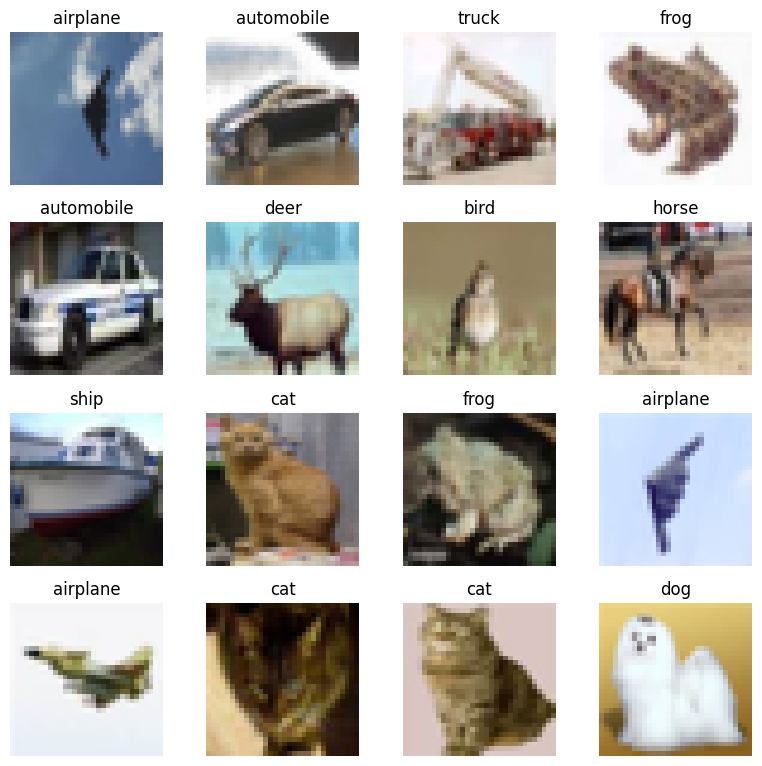

In [14]:
visualise_images(root_dir)

In [15]:
class Cifar10Dataset(torch.utils.data.Dataset):
    def __init__(self, target_dir: str, transform=None):
        self.root_dir = root_dir
        self.paths = list(target_dir.glob("*/*.png"))

        self.transform = transform
        self.class_names, self.class_to_idx = get_classes(target_dir)

    def load_image(self, index: int):
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self):
        return len(self.paths)

    # overwrite __getitem__() to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        image = self.load_image(index)
        class_name = self.paths[
            index
        ].parent.name  # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # if transform is necesarry
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx  # no transform

In [16]:
# Let's look at trivialaugment transform
train_transform = torchvision.transforms.Compose(
    [
        # torchvision.transforms.Resize((224, 224)),
        #         torchvision.transforms.TrivialAugmentWide(
        #             num_magnitude_bins=31
        #         ),  # num_magnitude_bins denotes how intense the augmentation happens
        torchvision.transforms.ToTensor(),
    ]
)

test_transform = torchvision.transforms.Compose(
    [
        # torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ]
)

In [17]:
train_dataset = Cifar10Dataset(target_dir=train_dir, transform=train_transform)
test_dataset = Cifar10Dataset(target_dir=test_dir, transform=test_transform)

In [18]:
def display_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str] = None,
    n: int = 10,
    display_shape: bool = True,
    seed: int = None,
):

    if n > 10:
        n = 10
        display_shape = False

    if seed:
        random.seed(seed)

    random_images_indices = random.sample(
        population=range(len(dataset)), k=n
    )  # get n number of random images from the dataset

    plt.figure(figsize=(20, 6))

    for i, target in enumerate(random_images_indices):
        target_image, target_label = dataset[target][0], dataset[target][1]
        target_image_adjust = torch.tensor(np.asarray(target_image)).permute(
            1, 2, 0
        )  # convert CHW to HWC
        plt.subplot(1, n, i + 1)
        plt.imshow(target_image_adjust)
        plt.axis("off")
        if class_names:
            title = f"Class: {classes[target_label]}"
            if display_shape:
                title += f"\nShape: {target_image_adjust.shape}"
        plt.title(title)

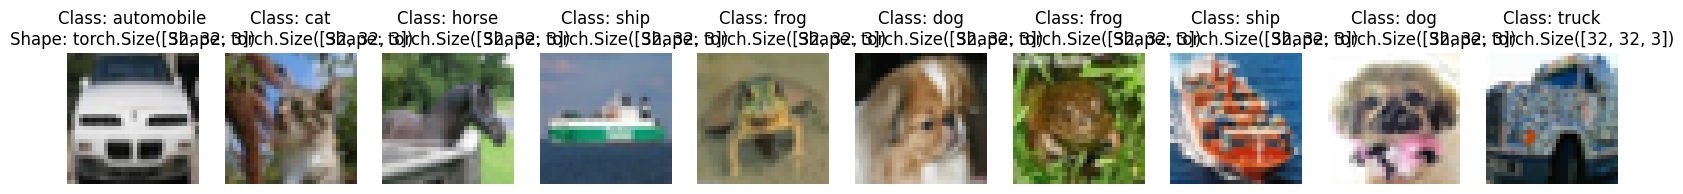

In [19]:
display_random_images(dataset=test_dataset, classes=class_names)

In [20]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE
)

## Patchifying the image

In [25]:
def show_patched_image(image, label, patch_size: int = 16):
    assert image.shape[0] in list(
        range(1, 4)
    ), "Image should be of shape (CHW), got (HWC)"
    height, width = image.shape[1:]
    num_patches = (height * width) // (patch_size**2)

    figure, axes = plt.subplots(
        nrows=(width // patch_size),
        ncols=(height // patch_size),
        sharex=True,
        sharey=True,
        figsize=(patch_size / 2, patch_size / 2),
    )

    for x, patch_x in enumerate(range(0, width, patch_size)):
        for y, patch_y in enumerate(range(0, height, patch_size)):
            image_patch = image[
                :, patch_y : patch_y + patch_size, patch_x : patch_x + patch_size
            ].permute(1, 2, 0)
            axes[x][y].imshow(image_patch)
            axes[x][y].set_ylabel(x + 1)
            axes[x][y].set_xticks([])
            axes[x][y].set_yticks([])
            axes[x][y].label_outer()
    figure.suptitle(f"{label} -> Patchified")

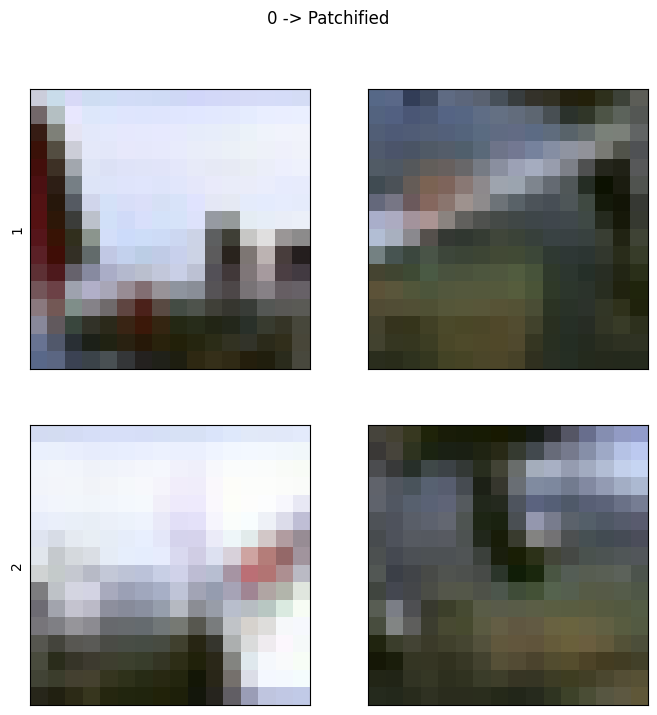

In [26]:
show_patched_image(image, label, patch_size=16)

In [27]:
### Training the model
model = Vit(patch_size=16, embedding_dim=768, image_size=32)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0
)

In [28]:
EPOCHS = 50

In [25]:
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    epochs=EPOCHS,
    device="cuda",
)

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.9279 | train_acc: 0.2932 | test_loss: 1.7809 | test_acc: 0.3608


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 1.7956 | train_acc: 0.3448 | test_loss: 1.7039 | test_acc: 0.3769


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 1.6590 | train_acc: 0.3982 | test_loss: 1.5903 | test_acc: 0.4234


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 1.5978 | train_acc: 0.4226 | test_loss: 1.5580 | test_acc: 0.4382


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 1.5415 | train_acc: 0.4418 | test_loss: 1.4852 | test_acc: 0.4705


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6 | train_loss: 1.4933 | train_acc: 0.4606 | test_loss: 1.4735 | test_acc: 0.4751


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7 | train_loss: 1.4542 | train_acc: 0.4788 | test_loss: 1.4389 | test_acc: 0.4868


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 8 | train_loss: 1.4250 | train_acc: 0.4884 | test_loss: 1.4369 | test_acc: 0.4814


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 9 | train_loss: 1.3936 | train_acc: 0.4993 | test_loss: 1.4065 | test_acc: 0.5010


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 10 | train_loss: 1.3619 | train_acc: 0.5132 | test_loss: 1.4085 | test_acc: 0.4925


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 11 | train_loss: 1.3292 | train_acc: 0.5226 | test_loss: 1.3632 | test_acc: 0.5196


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 12 | train_loss: 1.2975 | train_acc: 0.5356 | test_loss: 1.3527 | test_acc: 0.5211


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 13 | train_loss: 1.2730 | train_acc: 0.5414 | test_loss: 1.3544 | test_acc: 0.5236


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 14 | train_loss: 1.2423 | train_acc: 0.5555 | test_loss: 1.3500 | test_acc: 0.5189


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 15 | train_loss: 1.2187 | train_acc: 0.5632 | test_loss: 1.3312 | test_acc: 0.5248


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 16 | train_loss: 1.1915 | train_acc: 0.5739 | test_loss: 1.3252 | test_acc: 0.5337


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 17 | train_loss: 1.1666 | train_acc: 0.5832 | test_loss: 1.3251 | test_acc: 0.5288


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 18 | train_loss: 1.1383 | train_acc: 0.5897 | test_loss: 1.3481 | test_acc: 0.5300


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 19 | train_loss: 1.1176 | train_acc: 0.5981 | test_loss: 1.3162 | test_acc: 0.5363


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 20 | train_loss: 1.0871 | train_acc: 0.6095 | test_loss: 1.3529 | test_acc: 0.5300


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 21 | train_loss: 1.0611 | train_acc: 0.6185 | test_loss: 1.3269 | test_acc: 0.5396


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 22 | train_loss: 1.0265 | train_acc: 0.6328 | test_loss: 1.3232 | test_acc: 0.5416


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 23 | train_loss: 0.9952 | train_acc: 0.6427 | test_loss: 1.3506 | test_acc: 0.5400


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 24 | train_loss: 0.9545 | train_acc: 0.6584 | test_loss: 1.3620 | test_acc: 0.5420


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 25 | train_loss: 0.9139 | train_acc: 0.6703 | test_loss: 1.4017 | test_acc: 0.5424


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 26 | train_loss: 0.8808 | train_acc: 0.6833 | test_loss: 1.4016 | test_acc: 0.5358


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 27 | train_loss: 0.8736 | train_acc: 0.6837 | test_loss: 1.4094 | test_acc: 0.5406


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 28 | train_loss: 0.8266 | train_acc: 0.7017 | test_loss: 1.4565 | test_acc: 0.5379


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 29 | train_loss: 0.7723 | train_acc: 0.7215 | test_loss: 1.4166 | test_acc: 0.5399


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 30 | train_loss: 0.7229 | train_acc: 0.7408 | test_loss: 1.5308 | test_acc: 0.5300


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 31 | train_loss: 0.6597 | train_acc: 0.7606 | test_loss: 1.5713 | test_acc: 0.5369


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 32 | train_loss: 0.6016 | train_acc: 0.7822 | test_loss: 1.6614 | test_acc: 0.5308


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 33 | train_loss: 0.5608 | train_acc: 0.7938 | test_loss: 1.6286 | test_acc: 0.5372


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 34 | train_loss: 0.5006 | train_acc: 0.8198 | test_loss: 1.6885 | test_acc: 0.5409


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 35 | train_loss: 0.4457 | train_acc: 0.8397 | test_loss: 1.8685 | test_acc: 0.5339


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 36 | train_loss: 0.4239 | train_acc: 0.8470 | test_loss: 1.7901 | test_acc: 0.5366


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 37 | train_loss: 0.3677 | train_acc: 0.8668 | test_loss: 1.8973 | test_acc: 0.5474


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 38 | train_loss: 0.3253 | train_acc: 0.8824 | test_loss: 1.9746 | test_acc: 0.5349


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 39 | train_loss: 0.3052 | train_acc: 0.8905 | test_loss: 2.1071 | test_acc: 0.5369


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 40 | train_loss: 0.2722 | train_acc: 0.9026 | test_loss: 2.0917 | test_acc: 0.5446


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 41 | train_loss: 0.2501 | train_acc: 0.9088 | test_loss: 2.1227 | test_acc: 0.5384


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 42 | train_loss: 0.2372 | train_acc: 0.9145 | test_loss: 2.1728 | test_acc: 0.5453


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 43 | train_loss: 0.2232 | train_acc: 0.9196 | test_loss: 2.2216 | test_acc: 0.5348


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 44 | train_loss: 0.2028 | train_acc: 0.9278 | test_loss: 2.2177 | test_acc: 0.5433


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 45 | train_loss: 0.2004 | train_acc: 0.9277 | test_loss: 2.2672 | test_acc: 0.5375


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 46 | train_loss: 0.1872 | train_acc: 0.9343 | test_loss: 2.2798 | test_acc: 0.5441


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 47 | train_loss: 0.1833 | train_acc: 0.9355 | test_loss: 2.2214 | test_acc: 0.5470


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 48 | train_loss: 0.1651 | train_acc: 0.9412 | test_loss: 2.3424 | test_acc: 0.5381


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 49 | train_loss: 0.1534 | train_acc: 0.9445 | test_loss: 2.4319 | test_acc: 0.5423


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 50 | train_loss: 0.1481 | train_acc: 0.9471 | test_loss: 2.4595 | test_acc: 0.5466


The model is currently overfitting.